# Домашнее задание

ML разработчикам необходимо не только уметь обучать нейронные сети и генерировать новые идеи, но еще и уметь в страивать наработки в pipeline. В этом домашнем задании нам предстоит сделать из frustum детектора production ready (ну почти) решение, которое может работать на сырых данных.

К сожалению, frustum-pointnet работает независимо для каждой 2D детекции. В этом домашнем задании вам предстоит написать обертку над frustum-pointnet, которая будет работать над целыми облаками. Вам также нужно будет воспользоваться 2D детектором, чтобы находить коробки на изображении.

Во второй части задания вам нужно будет написать оценку качества работы вашего алгоритма, которая становится чуть сложнее, когда на сцене могут находится много объектов.

## Часть 1

Ниже написан класс, который вам нужно реализовать. Чтобы воспользоваться предобученной сетью, позаимствуйте код из
https://github.com/charlesq34/frustum-pointnets/blob/master/train/test.py

Предобученные модели лежат здесь: https://shapenet.cs.stanford.edu/media/frustum_pointnets_snapshots.zip

В частности, вам нужно модифицировать функцию `get_session_and_ops` - функция должна уметь работать без глобальных флагов. После этого посмотрите, как эта функция используется.
Выход сети преобразуется в понятный формат в функции `write_detection_results`.

In [5]:
from ssd import SSD
import ssd
import pickle
import os

In [6]:
from kitti_object import get_lidar_in_image_fov

In [7]:
import provider

BATCH_SIZE = 4
CLOUD_SIZE = 1024
import frustum_pointnets_v1

import tensorflow as tf

In [8]:
from tqdm.notebook import tqdm

In [9]:
def ser_mod(x, y):
    return x % y if x >= y else y - x

In [46]:
NUM_CLASSES = 2
NUM_CHANNEL = 4
from model_util import NUM_HEADING_BIN, NUM_SIZE_CLUSTER


def softmax(x):
    ''' Numpy function for softmax'''
    shape = x.shape
    probs = np.exp(x - np.max(x, axis=len(shape)-1, keepdims=True))
    probs /= np.sum(probs, axis=len(shape)-1, keepdims=True)
    return probs

def inference(sess, ops, pc, one_hot_vec, batch_size):
    ''' Run inference for frustum pointnets in batch mode '''
    orig_size = pc.shape[0]
    if pc.shape[0]%batch_size != 0:
        num_repeat = ser_mod(pc.shape[0], batch_size)
        for _ in range(num_repeat):
            pc = np.append(pc, np.expand_dims(pc[-1], axis=0), axis=0)
            one_hot_vec = np.append(one_hot_vec, np.expand_dims(one_hot_vec[-1], axis=0), axis=0)
    num_batches = int(pc.shape[0]/batch_size)
    logits = np.zeros((pc.shape[0], pc.shape[1], NUM_CLASSES))
    centers = np.zeros((pc.shape[0], 3))
    heading_logits = np.zeros((pc.shape[0], NUM_HEADING_BIN))
    heading_residuals = np.zeros((pc.shape[0], NUM_HEADING_BIN))
    size_logits = np.zeros((pc.shape[0], NUM_SIZE_CLUSTER))
    size_residuals = np.zeros((pc.shape[0], NUM_SIZE_CLUSTER, 3))
    scores = np.zeros((pc.shape[0],)) # 3D box score 
   
    ep = ops['end_points'] 
    for i in range(num_batches):
        feed_dict = {\
            ops['pointclouds_pl']: pc[i*batch_size:(i+1)*batch_size,...],
            ops['one_hot_vec_pl']: one_hot_vec[i*batch_size:(i+1)*batch_size,:],
            ops['is_training_pl']: False}
        batch_logits, batch_centers, \
        batch_heading_scores, batch_heading_residuals, \
        batch_size_scores, batch_size_residuals = \
            sess.run([ops['logits'], ops['center'],
                ep['heading_scores'], ep['heading_residuals'],
                ep['size_scores'], ep['size_residuals']],
                feed_dict=feed_dict)

        logits[i*batch_size:(i+1)*batch_size,...] = batch_logits
        centers[i*batch_size:(i+1)*batch_size,...] = batch_centers
        heading_logits[i*batch_size:(i+1)*batch_size,...] = batch_heading_scores
        heading_residuals[i*batch_size:(i+1)*batch_size,...] = batch_heading_residuals
        size_logits[i*batch_size:(i+1)*batch_size,...] = batch_size_scores
        size_residuals[i*batch_size:(i+1)*batch_size,...] = batch_size_residuals

        # Compute scores
        batch_seg_prob = softmax(batch_logits)[:,:,1] # BxN
        batch_seg_mask = np.argmax(batch_logits, 2) # BxN
        mask_mean_prob = np.sum(batch_seg_prob * batch_seg_mask, 1) # B,
        mask_mean_prob = mask_mean_prob / np.sum(batch_seg_mask,1) # B,
        heading_prob = np.max(softmax(batch_heading_scores),1) # B
        size_prob = np.max(softmax(batch_size_scores),1) # B,
        batch_scores = np.log(mask_mean_prob) + np.log(heading_prob) + np.log(size_prob)
        scores[i*batch_size:(i+1)*batch_size] = batch_scores 
        # Finished computing scores

    heading_cls = np.argmax(heading_logits, 1) # B
    size_cls = np.argmax(size_logits, 1) # B
    heading_res = np.array([heading_residuals[i,heading_cls[i]] \
        for i in range(pc.shape[0])])
    size_res = np.vstack([size_residuals[i,size_cls[i],:] \
        for i in range(pc.shape[0])])
    return np.argmax(logits, 2)[:orig_size], centers[:orig_size], heading_cls[:orig_size], heading_res[:orig_size], \
        size_cls[:orig_size], size_res[:orig_size], scores[:orig_size]

In [47]:
def get_session_and_ops(batch_size, num_point, model, model_path):
    ''' Define model graph, load model parameters,
    create session and return session handle and tensors
    '''
    with tf.Graph().as_default():
        device_id = '/gpu:0'
        with tf.device(device_id):
            pointclouds_pl, one_hot_vec_pl, labels_pl, centers_pl, \
            heading_class_label_pl, heading_residual_label_pl, \
            size_class_label_pl, size_residual_label_pl = \
                    model.placeholder_inputs(batch_size, num_point)
            is_training_pl = tf.placeholder(tf.bool, shape=())
            end_points = model.get_model(pointclouds_pl, one_hot_vec_pl,
                is_training_pl)
            saver = tf.train.Saver()

        # Create a session
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        config.allow_soft_placement = True
        sess = tf.Session(config=config)

        # Restore variables from disk.
        saver.restore(sess, model_path)
        ops = {'pointclouds_pl': pointclouds_pl,
               'one_hot_vec_pl': one_hot_vec_pl,
               'labels_pl': labels_pl,
               'centers_pl': centers_pl,
               'heading_class_label_pl': heading_class_label_pl,
               'heading_residual_label_pl': heading_residual_label_pl,
               'size_class_label_pl': size_class_label_pl,
               'size_residual_label_pl': size_residual_label_pl,
               'is_training_pl': is_training_pl,
               'logits': end_points['mask_logits'],
               'center': end_points['center'],
               'end_points': end_points,
              }
        return sess, ops

In [48]:
from collections import namedtuple

Detection = namedtuple('Detection', ['xyz', 'angle', 'lwh', 'confidence'])
Scene = namedtuple('Scene', ['detections'])

In [49]:
class PipelineDetector(object):
    def __init__(self, frustum_pointnet, frustum_batch_size, ssd_detector, ssd_threshold):
        self.sess, self.ops = frustum_pointnet
        self.frustum_batch_size = frustum_batch_size
        self.ssd_detector = ssd_detector
        self.ssd_threshold = ssd_threshold
        
    def predict(self, lidar, image, calibration, preds=None):

        # TODO: run 2D detector on the image
        if not preds:
            preds = self.ssd_detector.predict(image)
        # TODO: extract bounding boxes with vehicle classes and filter them by ssd_threshold
        preds_mask = (preds['detection_classes'] == ssd.CAR_CLASS) & (preds['detection_scores'] > self.ssd_threshold)
        preds_bboxes = preds['detection_boxes'][preds_mask]
        preds_scores = preds['detection_scores'][preds_mask]
        if len(preds_bboxes) == 0:
            return Scene([])
        # TODO: process lidar point cloud and construct frustum examples
        img_height, img_width, img_channel = image.shape
        _, pc_image_coord, img_fov_inds = get_lidar_in_image_fov(lidar[:, :3],
            calibration, 0, 0, img_width, img_height, True)
        clouds = []
        frustrum_angles = []
        one_hot_vecs = []


        for idx, (ymin, xmin, ymax, xmax) in enumerate(preds_bboxes):
            xmin *= img_width
            xmax *= img_width
            ymin *= img_height
            ymax *= img_height
            box_fov_inds = (pc_image_coord[:,0]<xmax) & \
            (pc_image_coord[:,0]>=xmin) & \
            (pc_image_coord[:,1]<ymax) & \
            (pc_image_coord[:,1]>=ymin)
            box_fov_inds = box_fov_inds & img_fov_inds
            lidar_filtered = lidar[box_fov_inds]
            if len(lidar_filtered) == 0:
                continue

            box2d_center = np.array([(xmin+xmax)/2.0, (ymin+ymax)/2.0])
            uvdepth = np.zeros((1,3))
            uvdepth[0,0:2] = box2d_center
            uvdepth[0,2] = 20 # some random depth
            box2d_center_rect = calibration.project_image_to_rect(uvdepth)
            frustrum_angle = -1 * np.arctan2(box2d_center_rect[0,2],
                box2d_center_rect[0,0]) + np.pi / 2
            frustrum_angles.append(frustrum_angle)

            choice = np.random.choice(len(lidar_filtered), CLOUD_SIZE, replace=True)
            cloud = lidar_filtered[choice]
            cloud[:, :3] = calibration.project_velo_to_ref(cloud[:, :3])
            cloud[:, :3] = provider.rotate_pc_along_y(cloud[:, :3], frustrum_angle)
            clouds.append(cloud)
            one_hot_vec = np.array((1.0, 0.0, 0.0))
            one_hot_vecs.append(one_hot_vec)

        # TODO: run frustum inference (use batch to accelerate inference per frame)
        outputs, center_preds, hclass_preds, hres_preds, sclass_preds, sres_preds, scores = \
        inference(self.sess, self.ops, np.stack(clouds), np.vstack(one_hot_vecs), self.frustum_batch_size)
        detections = []
        # TODO: construct Scene namedtuple and return it
        for center_pred, hclass_pred, hres_pred, sclass_pred, sres_pred, angle, score_ssd in zip(
        center_preds, hclass_preds, hres_preds, sclass_preds, sres_preds, frustrum_angles, preds_scores):
            h, w, l, tx, ty, tz, ry = provider.from_prediction_to_label_format(
                center_pred, hclass_pred, hres_pred, sclass_pred, sres_pred, angle)
            detections.append(Detection(np.array([tx, ty, tz]), ry, np.array((l, w, h)), score_ssd))
        return Scene(detections)
    

### 2D детектор

В файле ssd.py есть детектор (файл называется ssd, но на самом деле там faster-rcnn), обученный на kitti. У него можно позвать predict на одном изображении. Коробки возвращаются в нормализованных координатах картинки. Класс 1 соответствует машинам, 2 - пешеходам.

In [50]:
detector = SSD('tmp')

## Часть 2

Для оценки качества работы 3D детекторов обычно используется average precision. Как измерить precision и recall детектора?

У каждой коробки детектора есть confidence. После того, как мы зафиксировали порог, у нас остается часть детекций.
Давайте теперь посмотрим на сцену сверху: bird's eye view. Забудем про координату z.

Далее мы можем посчитать IoU между всеми коробками ground truth и нашими детекциями.Давайте решим, что если IoU больше 0.7, то мы будем считать, что мы увидели gt коробку - относим эту детекцию к TP. Если gt не нашла пару - False Negative. Если детекция не нашла пару - False Positive.

Ваша задача написать код подсчета метрики average precision построенного детектора.

# Kitti Dataset
[Kitti dev-kit](https://s3.eu-central-1.amazonaws.com/avg-kitti/devkit_object.zip) : 
там можно найти описание данных и как преобразовывать данные между системами координат.

Homework KITTI dataset :https://www.icloud.com/iclouddrive/0bxlXWgCRTVvsWXmd-kcEqKqA#kitti_hw_dataset

In [51]:
import numpy as np
from matplotlib import pyplot as plt 

In [52]:
import kitti_object

In [53]:
IOU_THRESHOLD = 0.7

CARS_CLASSES = {
  'Car',
  'Van',
  'Track'
}

In [112]:
kitti_dataset_root = '.'
kitti_dataset = kitti_object.kitti_object(root_dir=kitti_dataset_root)
sample_id = 8
image = kitti_dataset.get_image(sample_id)
lidar = kitti_dataset.get_lidar(sample_id)
calibration = kitti_dataset.get_calibration(sample_id)
labels = kitti_dataset.get_label_objects(sample_id)
labels = [label for label in labels if label.type in CARS_CLASSES]

In [113]:
pipeline_detector = PipelineDetector(get_session_and_ops(BATCH_SIZE, CLOUD_SIZE, frustum_pointnets_v1, 
                               'frustum_pointnets_snapshots/log_v1/model.ckpt'), BATCH_SIZE, detector, 0.0)

INFO:tensorflow:Restoring parameters from frustum_pointnets_snapshots/log_v1/model.ckpt


In [114]:
preds = detector.predict(image)

In [115]:
scene = pipeline_detector.predict(lidar, image, calibration, preds=preds)

Будем использовать библиотеку shapely, дабы не писать самостоятельно кучу кода для поворотов, intersection и тд

In [116]:
MAX_DISTANCE=40

In [117]:
from shapely.geometry import Polygon
from shapely.affinity import rotate


In [118]:
def label_to_detection(label):
    return Detection(label.t, label.ry, np.array((label.l, label.w, label.h)), 1.)

In [119]:
def get_polygon_coords(x, y, l, w, angle):
    polygon = rotate(Polygon([[-w/2, -l/2], [-w/2, l/2], [w/2, l/2], [w/2, -l/2]]), -angle, use_radians=True)
    coords = np.array(polygon.exterior.coords)
    coords[:, 0] += x
    coords[:, 1] += y
    return Polygon([coords[0], coords[1], coords[2], coords[3]])

In [120]:
def get_boxes_coords(detections, calibration):
    boxes = []
    for detection in detections:
        x, y, _ = calibration.project_ref_to_velo(np.expand_dims(detection.xyz, 0))[0]
        box_coords = get_polygon_coords(x, y, *detection.lwh[:2], detection.angle)
        #filter far boxes
        if box_coords.centroid.x ** 2 + box_coords.centroid.y ** 2 <= MAX_DISTANCE**2:
            boxes.append(box_coords)
    return boxes

In [121]:
label_boxes = get_boxes_coords(list(map(label_to_detection, labels)), calibration)

pred_boxes = get_boxes_coords(scene.detections, calibration)

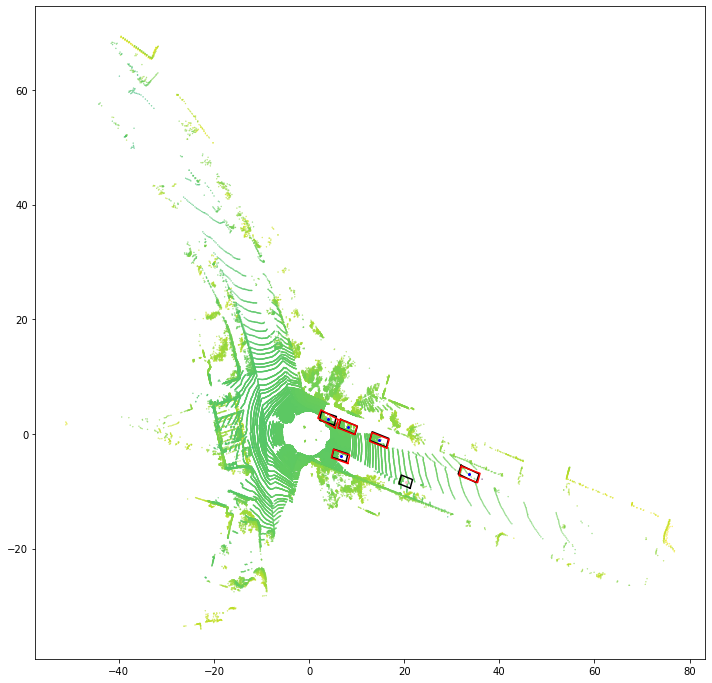

In [122]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.scatter(lidar[:, 0], lidar[:, 1], c=lidar[:, 2],  s=0.1)
for box in label_boxes:
    coords = np.array(box.exterior.coords)
    ax.plot(coords[:, 0], coords[:, 1], c='black')
    ax.scatter([box.centroid.x], [box.centroid.y], c='pink', s=4)

for box in pred_boxes:
    coords = np.array(box.exterior.coords)
    ax.plot(coords[:, 0], coords[:, 1], c='red')
    ax.scatter([box.centroid.x], [box.centroid.y], c='blue', s=4)

plt.show()

Следующие куски кода взяты из того же репозитория и совсем чуть-чуть подправлены

In [123]:
def voc_ap(rec, prec, use_07_metric=False):
    """ ap = voc_ap(rec, prec, [use_07_metric])
    Compute VOC AP given precision and recall.
    If use_07_metric is true, uses the
    VOC 07 11 point method (default:False).
    """
    if use_07_metric:
        # 11 point metric
        ap = 0.
        for t in np.arange(0., 1.1, 0.1):
            if np.sum(rec >= t) == 0:
                p = 0
            else:
                p = np.max(prec[rec >= t])
            ap = ap + p / 11.
    else:
        # correct AP calculation
        # first append sentinel values at the end
        mrec = np.concatenate(([0.], rec, [1.]))
        mpre = np.concatenate(([0.], prec, [0.]))

        # compute the precision envelope
        for i in range(mpre.size - 1, 0, -1):
            mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

        # to calculate area under PR curve, look for points
        # where X axis (recall) changes value
        i = np.where(mrec[1:] != mrec[:-1])[0]

        # and sum (\Delta recall) * prec
        ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap

In [124]:
def get_iou(box1, box2):
    return box1.intersection(box2).area / box1.union(box2).area

In [125]:
def eval_det_cls(pred, gt, ovthresh=0.25, use_07_metric=False):
    """ Generic functions to compute precision/recall for object detection
        for a single class.
        Input:
            pred: map of {img_id: [(bbox, score)]} where bbox is numpy array
            gt: map of {img_id: [bbox]}
            ovthresh: scalar, iou threshold
            use_07_metric: bool, if True use VOC07 11 point method
        Output:
            rec: numpy array of length nd
            prec: numpy array of length nd
            ap: scalar, average precision
    """

    # construct gt objects
    class_recs = {} # {img_id: {'bbox': bbox list, 'det': matched list}}
    npos = 0
    for img_id in gt.keys():
        bbox = np.array(gt[img_id])
        det = [False] * len(bbox)
        npos += len(bbox)
        class_recs[img_id] = {'bbox': bbox, 'det': det}
    # pad empty list to all other imgids
    for img_id in pred.keys():
        if img_id not in gt:
            class_recs[img_id] = {'bbox': np.array([]), 'det': []}

    # construct dets
    image_ids = []
    confidence = []
    BB = []
    for img_id in pred.keys():
        for box,score in pred[img_id]:
            image_ids.append(img_id)
            confidence.append(score)
            BB.append(box)
    confidence = np.array(confidence)
    BB = np.array(BB) # (nd,4 or 8,3)

    # sort by confidence
    sorted_ind = np.argsort(-confidence)
    sorted_scores = np.sort(-confidence)
    BB = BB[sorted_ind, ...]
    image_ids = [image_ids[x] for x in sorted_ind]

    # go down dets and mark TPs and FPs
    nd = len(image_ids)
    tp = np.zeros(nd)
    fp = np.zeros(nd)
    for d in range(nd):
        if d%100==0: print(d)
        R = class_recs[image_ids[d]]
        bb = BB[d]
        ovmax = -np.inf
        BBGT = R['bbox']

        if BBGT.size > 0:
            # compute overlaps
            for j in range(BBGT.shape[0]):
                iou = get_iou(bb, BBGT[j]) 
                if iou > ovmax:
                    ovmax = iou
                    jmax = j

        #print d, ovmax
        if ovmax > ovthresh:
            if not R['det'][jmax]:
                tp[d] = 1.
                R['det'][jmax] = 1
            else:
                fp[d] = 1.
        else:
            fp[d] = 1.

    # compute precision recall
    fp = np.cumsum(fp)
    tp = np.cumsum(tp)
    rec = tp / float(npos)
    print('NPOS: ', npos)
    # avoid divide by zero in case the first detection matches a difficult
    # ground truth
    prec = tp / np.maximum(tp + fp, np.finfo(np.float64).eps)
    ap = voc_ap(rec, prec, use_07_metric)

    return rec, prec, ap

In [126]:
preds_sample = {8: [(pred_box, detection.confidence) for pred_box, detection in zip(pred_boxes, scene.detections)]}
labels_sample = {8: label_boxes}
rec, prec, ap = eval_det_cls(preds_sample, labels_sample, ovthresh=IOU_THRESHOLD)
ap

0
NPOS:  6


0.5333333333333333

In [100]:
indexes = list(map(lambda x: int(x.split('.')[0]), os.listdir('training/calib')))

In [101]:
len(indexes)

1000

In [102]:
kitti_dataset_root = '.'
kitti_dataset = kitti_object.kitti_object(root_dir=kitti_dataset_root)

In [103]:
sample_preds = {}
sample_labels = {}

for sample_id in tqdm(indexes):
    image = kitti_dataset.get_image(sample_id)
    lidar = kitti_dataset.get_lidar(sample_id)
    calibration = kitti_dataset.get_calibration(sample_id)
    labels = kitti_dataset.get_label_objects(sample_id)
    labels = [label for label in labels if label.type in CARS_CLASSES]
    scene = pipeline_detector.predict(lidar, image, calibration)
    label_boxes = get_boxes_coords(list(map(label_to_detection, labels)), calibration)
    pred_boxes = get_boxes_coords(scene.detections, calibration)
    sample_preds[sample_id] = [(pred_box, detection.confidence) for pred_box, detection in zip(pred_boxes, scene.detections)]
    sample_labels[sample_id] = label_boxes

/opt/conda/envs/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide


In [104]:
rec, prec, ap = eval_det_cls(sample_preds, sample_labels, ovthresh=IOU_THRESHOLD)
ap

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
NPOS:  2998


0.501075873358823

In [105]:
xyzi = np.fromfile('training/velodyne/000100.bin', dtype=np.float32).reshape(-1, 4)

In [106]:
xyzi

array([[43.889,  0.084,  1.693,  0.   ],
       [43.201,  0.218,  1.67 ,  0.   ],
       [42.397,  0.347,  1.643,  0.   ],
       ...,
       [ 3.696, -1.398, -1.726,  0.31 ],
       [ 3.717, -1.399, -1.736,  0.35 ],
       [ 3.724, -1.389, -1.737,  0.   ]], dtype=float32)

(-50.0, 50.0)

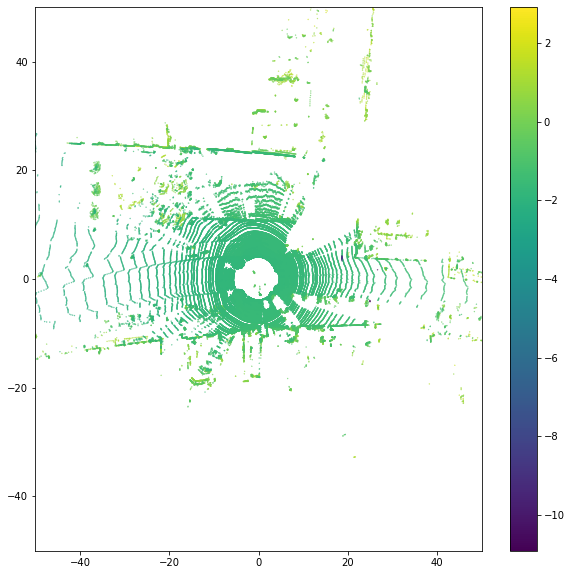

In [107]:
plt.figure(figsize=(10, 10))
plt.scatter(xyzi[:, 0], xyzi[:, 1], c=xyzi[:, 2],  s=0.1)
plt.colorbar()
plt.xlim(-50, 50)
plt.ylim(-50, 50)

In [108]:
import PIL.Image as Image

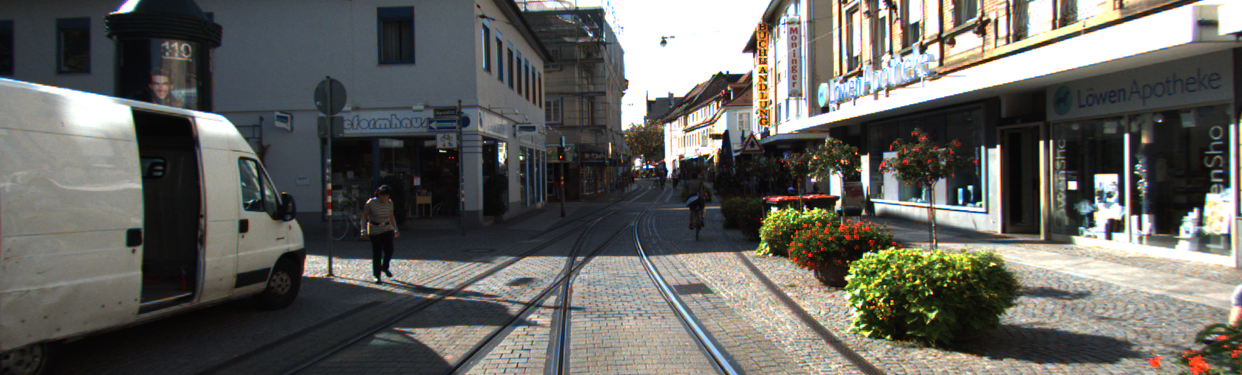

In [109]:
Image.open('training/image_2/000100.png')

In [110]:
with open('training/calib/000100.txt') as f:
    print(f.read())

P0: 7.215377000000e+02 0.000000000000e+00 6.095593000000e+02 0.000000000000e+00 0.000000000000e+00 7.215377000000e+02 1.728540000000e+02 0.000000000000e+00 0.000000000000e+00 0.000000000000e+00 1.000000000000e+00 0.000000000000e+00
P1: 7.215377000000e+02 0.000000000000e+00 6.095593000000e+02 -3.875744000000e+02 0.000000000000e+00 7.215377000000e+02 1.728540000000e+02 0.000000000000e+00 0.000000000000e+00 0.000000000000e+00 1.000000000000e+00 0.000000000000e+00
P2: 7.215377000000e+02 0.000000000000e+00 6.095593000000e+02 4.485728000000e+01 0.000000000000e+00 7.215377000000e+02 1.728540000000e+02 2.163791000000e-01 0.000000000000e+00 0.000000000000e+00 1.000000000000e+00 2.745884000000e-03
P3: 7.215377000000e+02 0.000000000000e+00 6.095593000000e+02 -3.395242000000e+02 0.000000000000e+00 7.215377000000e+02 1.728540000000e+02 2.199936000000e+00 0.000000000000e+00 0.000000000000e+00 1.000000000000e+00 2.729905000000e-03
R0_rect: 9.999239000000e-01 9.837760000000e-03 -7.445048000000e-03 -9.

In [111]:
with open('training/label_2/000100.txt') as f:
    print(f.read())

Van 0.63 0 -0.90 0.00 58.65 320.90 374.00 2.46 2.03 5.35 -5.18 1.69 7.24 -1.51
Cyclist 0.00 0 -1.58 684.31 165.66 710.23 242.31 1.82 0.59 1.89 2.13 1.66 18.06 -1.47
Pedestrian 0.00 0 0.84 359.32 182.26 400.32 285.85 1.57 0.52 0.62 -3.63 1.72 11.35 0.54
Car 0.00 2 -2.46 19.88 179.87 206.64 238.00 1.44 1.62 3.91 -13.04 1.64 18.98 -3.05
DontCare -1 -1 -10 650.19 158.35 666.90 192.77 -1 -1 -1 -1000 -1000 -1000 -10

